In [100]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn import linear_model
import statsmodels.api as sm
from statsmodels.graphics.gofplots import ProbPlot
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

In [57]:
data_raw = pd.read_csv("../data/clean/full_dataset.csv")

In [58]:
data_raw.head()

,ID Number,Preferred Pronouns,Current Grade Level,Program,First Paying Job,Know employee,Applied Before,Comfortable speaking to crowd,Uncomfortable with,Extra activities,...,Application Year,Current Age,Rejected,EECode,EarnHours,EarnRate,EarnAmount,Dist Position Desc,Year,Month
0,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,5.50,13.0,71.50,WILD Steward,2022.0,4.0
1,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,14.47,13.0,188.11,WILD Steward,2022.0,5.0
2,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,7.13,13.0,92.69,WILD Steward,2022.0,5.0
3,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,130.38,13.0,1694.94,WILD Steward,2022.0,6.0
4,1489.0,masculine,9.0,zoocamp,1,0,0,1.0,invertebrates,0,...,2022,NaN,0,1489.0,123.80,13.0,1609.40,WILD Steward,2022.0,7.0


In [59]:
data_raw.columns

Index(['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode', 'EarnHours', 'EarnRate', 'EarnAmount', 'Dist Position Desc',
       'Year', 'Month'],
      dtype='object')

## Calculate monthly hours

In [60]:
#Sum up monthly earn hours
hours = data_raw[['ID Number','EarnHours','Year','Month']]
hours = hours.dropna().reset_index(drop = True)

In [68]:
hours_sum = hours.groupby(['ID Number','Year','Month']).agg({'EarnHours':'sum'}).add_suffix('_Sum').reset_index()
hours_sum = hours_sum.groupby(['ID Number']).agg({'EarnHours_Sum':'mean'}).add_suffix('_AvgPerMonth').reset_index()
hours_sum
#hours_sum.groupby(['ID Number']).rank(method='dense')
#hours_sum.pivot(index = 'ID Number', columns={'Year','Month'}, values='EarnHours_Sum')

,ID Number,EarnHours_Sum_AvgPerMonth
0,1154.0,24.831667
1,1155.0,25.070000
2,1156.0,27.921429
3,1158.0,37.409200
4,1160.0,40.462222
5,1161.0,36.945556
6,1162.0,33.465000
7,1163.0,44.670000
8,1164.0,76.846364
9,1165.0,20.953750


## Condense dataframe

In [228]:
# remove info on hours and dedupe
data = data_raw[['ID Number', 'Preferred Pronouns', 'Current Grade Level', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source', 'Application Year', 'Current Age', 'Rejected',
       'EECode']]

data = data.drop_duplicates().reset_index(drop=True)

# bring in summarized hours
data = data.merge(hours_sum, on=['ID Number'], how="left")

# fill unknown values
data['Current Grade Level'] = data['Current Grade Level'].fillna((data['Current Grade Level'].mean()))
data['Current Age'] = data['Current Age'].fillna((data['Current Age'].mean()))
data['Application Year'] = data['Application Year'].fillna((data['Application Year'].mean()))
data = data.fillna(value='unknown')

# one-hot encode values
data = pd.get_dummies(data, columns = ['Preferred Pronouns', 'Program',
       'First Paying Job', 'Know employee', 'Applied Before',
       'Comfortable speaking to crowd', 'Uncomfortable with',
       'Extra activities', 'Commit Summer', 'Commit Weekday',
       'Hear about source'])

## Define X, y

In [253]:
data.columns

Index(['ID Number', 'Current Grade Level', 'Application Year', 'Current Age',
       'Rejected', 'EECode', 'EarnHours_Sum_AvgPerMonth',
       'Preferred Pronouns_feminine', 'Preferred Pronouns_masculine',
       'Preferred Pronouns_neutral', 'Preferred Pronouns_unknown',
       'Program_homeschool', 'Program_other', 'Program_unknown',
       'Program_zoocamp', 'First Paying Job_0', 'First Paying Job_1',
       'Know employee_0', 'Know employee_1', 'Applied Before_0',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Comfortable speaking to crowd_unknown', 'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Uncomfortable with_unknown', 'Extra activities_0',
       'Extra activities_1', 'Commit Summer_unknown', 'Commit Summer_unsure',
       'Commit Summer_yes', 'Commit Weekday_no', 'Commit Weekday_unk

In [254]:
# Drop a column from one hot encoded values, specifically drop the _unknown columns where possible
# Pronouns have to be removed since they introduce perfect colinearity
X = data[['Current Grade Level', 'Application Year', 'Current Age','Program_homeschool', 'Program_other',
       'Program_zoocamp', 'First Paying Job_1',
       'Know employee_1',
       'Applied Before_1', 'Comfortable speaking to crowd_0.0',
       'Comfortable speaking to crowd_1.0',
       'Uncomfortable with_birds',
       'Uncomfortable with_invertebrates', 'Uncomfortable with_mammals',
       'Uncomfortable with_none', 'Uncomfortable with_reptiles',
       'Extra activities_1', 'Commit Summer_unsure',
       'Commit Summer_yes', 'Commit Weekday_no', 
       'Commit Weekday_unsure', 'Commit Weekday_yes',
       'Hear about source_family', 'Hear about source_friend',
       'Hear about source_other', 'Hear about source_school',
       'Hear about source_social media']]

y = data['Rejected']

In [231]:
# Identify perfect multicollinearity
for i,a in enumerate(X.columns):
    for j,b in enumerate(X.columns):
        k = sum(X[X.columns[i]]+X[X.columns[j]])
        if k == len(X):
            print(f"{a}, {b}: {k}")

First Paying Job_1, Know employee_1: 289
Know employee_1, First Paying Job_1: 289


In [232]:
X = X.drop(columns = ['Know employee_1'])

In [233]:
X

,Current Grade Level,Application Year,Current Age,Preferred Pronouns_feminine,Preferred Pronouns_masculine,Preferred Pronouns_neutral,Program_homeschool,Program_other,Program_zoocamp,First Paying Job_1,...,Commit Summer_unsure,Commit Summer_yes,Commit Weekday_no,Commit Weekday_unsure,Commit Weekday_yes,Hear about source_family,Hear about source_friend,Hear about source_other,Hear about source_school,Hear about source_social media
0,9.0,2022,15.339623,0,1,0,0,0,1,1,...,0,1,0,0,1,0,0,1,0,0
1,11.0,2022,15.339623,0,1,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
2,11.0,2022,15.339623,0,1,0,0,1,0,0,...,0,1,0,0,1,0,1,0,0,0
3,9.0,2022,15.339623,0,1,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
4,10.0,2022,15.339623,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,11.0,2020,16.000000,1,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
285,10.0,2020,15.000000,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
286,10.0,2020,15.000000,1,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
287,10.0,2020,15.000000,1,0,0,0,0,0,1,...,0,1,0,0,1,0,0,0,1,0


## Train model

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [258]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

LogisticRegression(solver='liblinear')

In [259]:
model.coef_

array([[-0.01920746,  0.00201575,  0.04396438,  0.10331238, -0.78216043,
         0.07124421, -0.40704898, -0.1005515 , -0.12806796,  0.31309788,
        -0.81122567,  0.40521542, -0.28462703,  0.40032862, -0.35268124,
        -0.28470649, -0.07732519,  0.35076407, -0.70568655,  0.02141061,
         0.44954413, -0.79542049, -0.27693195,  0.19427529, -0.36381006,
         0.57994572, -0.28979861]])

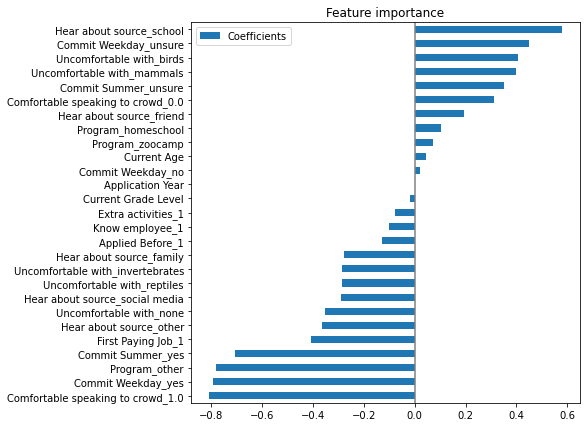

In [260]:
coefs = pd.DataFrame(
   model.coef_.transpose(),
   columns=['Coefficients'], index=X_train.columns
)

coefs = coefs.sort_values(by=['Coefficients'])
coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Feature importance')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

In [261]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(231, 27)
(58, 27)
(231,)
(58,)


In [262]:
regr = linear_model.LogisticRegression()
regr.fit(X, y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

# with statsmodels
x = sm.add_constant(X) # adding a constant
 
model = sm.Logit(y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Intercept: 
 [0.00170509]
Coefficients: 
 [[ 4.26224591e-02  6.42539261e-04  1.88505474e-01 -1.76809824e-01
  -9.45650191e-01 -2.87125076e-01 -2.87476704e-01 -4.35532405e-01
  -4.66896467e-02 -1.04122731e-02 -5.84030280e-01  5.38880772e-01
  -3.23021531e-01  2.27589099e-01 -2.24361577e-01 -3.52894168e-01
  -1.29538872e-01  1.89374562e-01 -6.87004569e-01  7.43294885e-02
   6.11021925e-01 -1.08570585e+00 -2.88718131e-01  3.20598304e-01
  -1.52138633e-01  5.91626446e-01 -6.45025747e-01]]
         Current function value: 0.311736
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               Rejected   No. Observations:                  289
Model:                          Logit   Df Residuals:                      262
Method:                           MLE   Df Model:                           26
Date:                Sun, 12 Feb 2023   Pseudo R-squ.:                  0.1853
Time:                        23:03:15   Log-Likel

C:\Users\lawto\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
